## House Prices - Advanced Regression Techniques

In this project we will be using a Kaggle Dataset containing 79 variables holding information about residential properties sold in Iowa. We will explore the data and identify key variables, process and clean the data and engineer new features. Once ready, we will attempt to predict the sale prices held within our test set and test the performance of our algorithm using root mean squared error (RMSE) & adjusted R squared.

As this problem requires a regression model, RMSE is a good performance measure. RMSE indicates how closely (in absolute terms) our predicted values are to the actual sale prices and is easy to interpret as it will be in the same units as the original Sale Price. R squared represents a value, from 0 to 1, showing how much of an improvement the model is over simply taking the mean, showing us the 'goodness of fit'. We will use a variant of this, 'adjusted R squared' which will adjust for having multiple variables, especially if they contribute nothing to the model. It should show us the proportion of total variance explained by the model.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Exploratory Data Analysis

After reading through some of the Data descriptions, there looks to be a few very useful variables such as LotArea & OverallQual. However, there are also many variables which probably will not assist us in predicting sales prices, such as 'Alley' and 'WoodDeckSF', also a lot of variables seem to hold duplicate information such as GarageCars and GarageArea which we may need to drop.

Let's have a look into our target variable and see how it is distributed.

In [6]:
train.describe()['SalePrice']

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

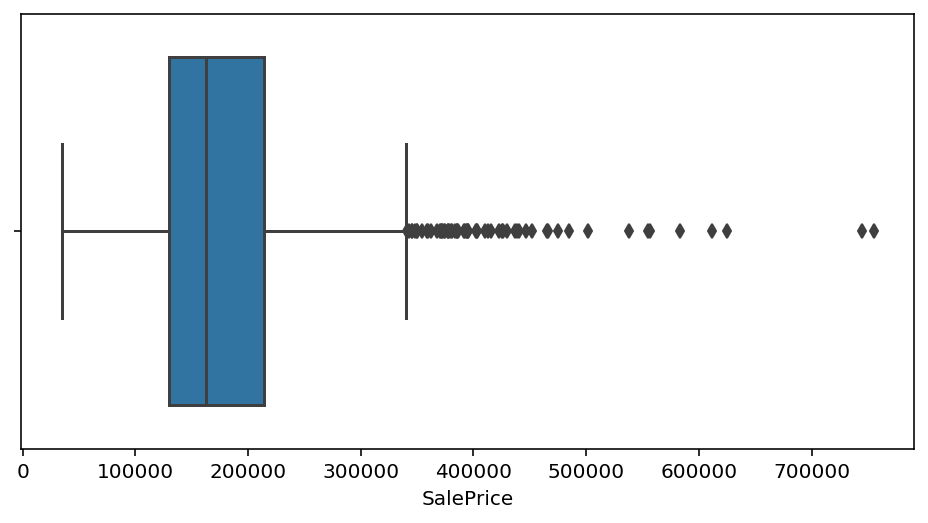

In [7]:
plt.figure(figsize=(8,4))
sns.boxplot(x='SalePrice',data=train)

Skew: 1.882876


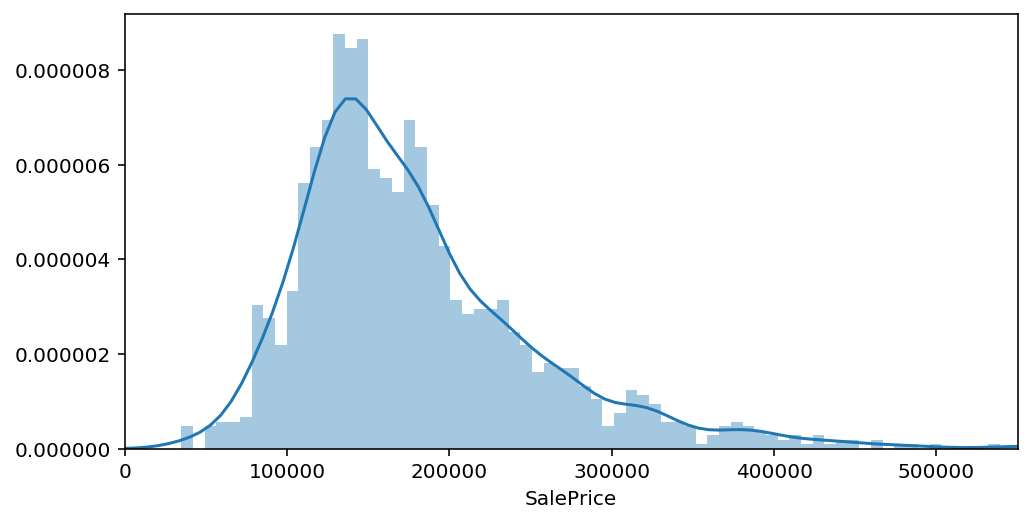

In [8]:
plt.figure(figsize=(8,4))
sns.distplot(train['SalePrice'],kde=True,bins=100)
plt.xlim(0,550000)
print("Skew: %f" % train['SalePrice'].skew())

We can see from the above visualisations that a lot of the sales prices fall into the 100,000 - 200,000 range with a mean of 180,000. However, we can also see that there are a few outliers, with values from ~ 600,000 upwards, as well as the fact that the SalePrice is not Normally distributed, shown by a Skew of 1.88. We will need to transform this variable later in order for many algorithms to be effective. Let's assess which numerical variables are most highly correlated with SalePrice.

### Continuous Variables

In [9]:
vars = train.corr()['SalePrice'].sort_values(ascending=False)[:15]
print(vars)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


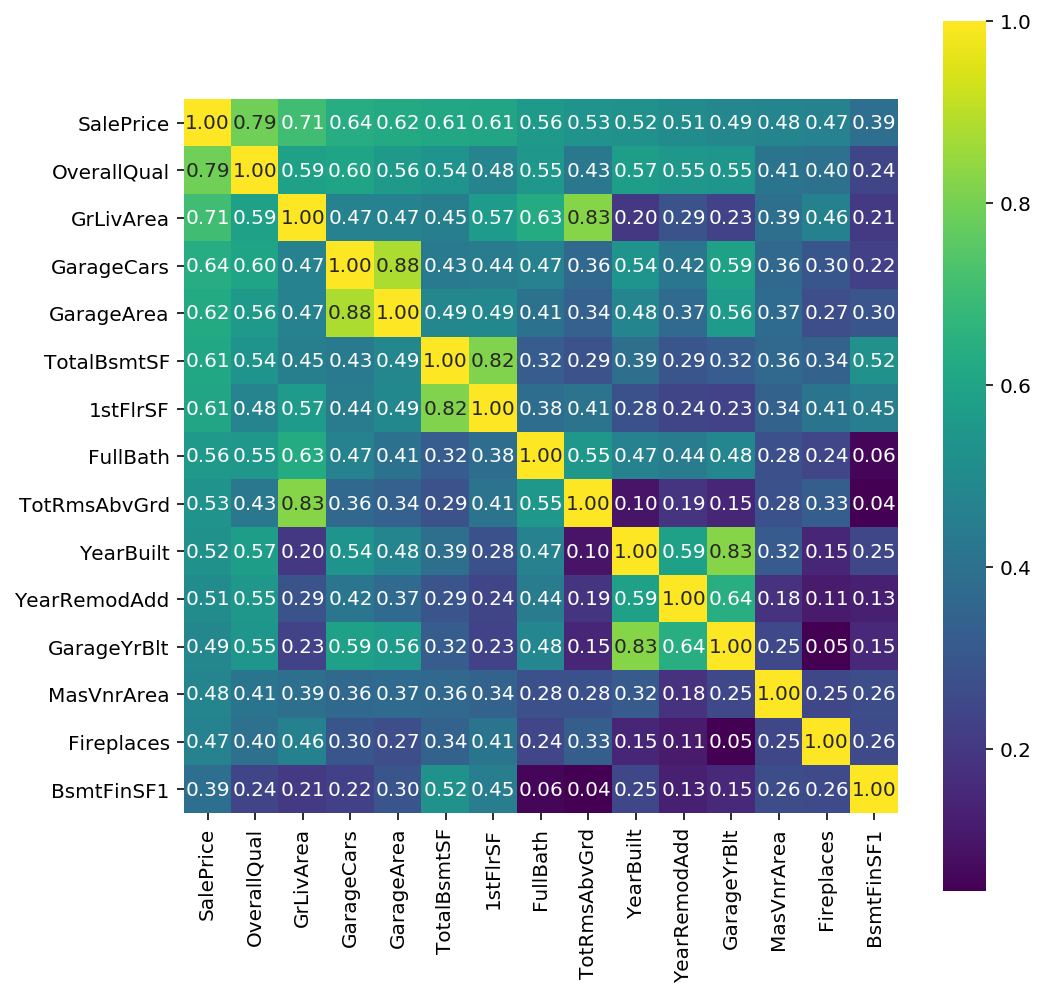

In [10]:
cols = train[vars.index]
plt.figure(figsize=(8,8))
sns.heatmap(cols.corr(), cbar=True, annot=True, square=True, fmt='.2f',cmap='viridis')

Using .corr() we can pick put the most highly correlated variables with SalePrice (there are no strong negative correlations). A lot of these make sense, OverallQual which was mentioned earlier, as well as GrLivArea stand out. However, we can see there are signs of multicolinearity here as some variables seem to be showing duplicated information. As a result we can drop TotRmsAbvGrd, GarageCars & 1stFlrSF. 

Using sns.pairplot & sns.jointplot we can visualise scatter plots between these variables, this can give us a good feel for how these varaibles are distributed.

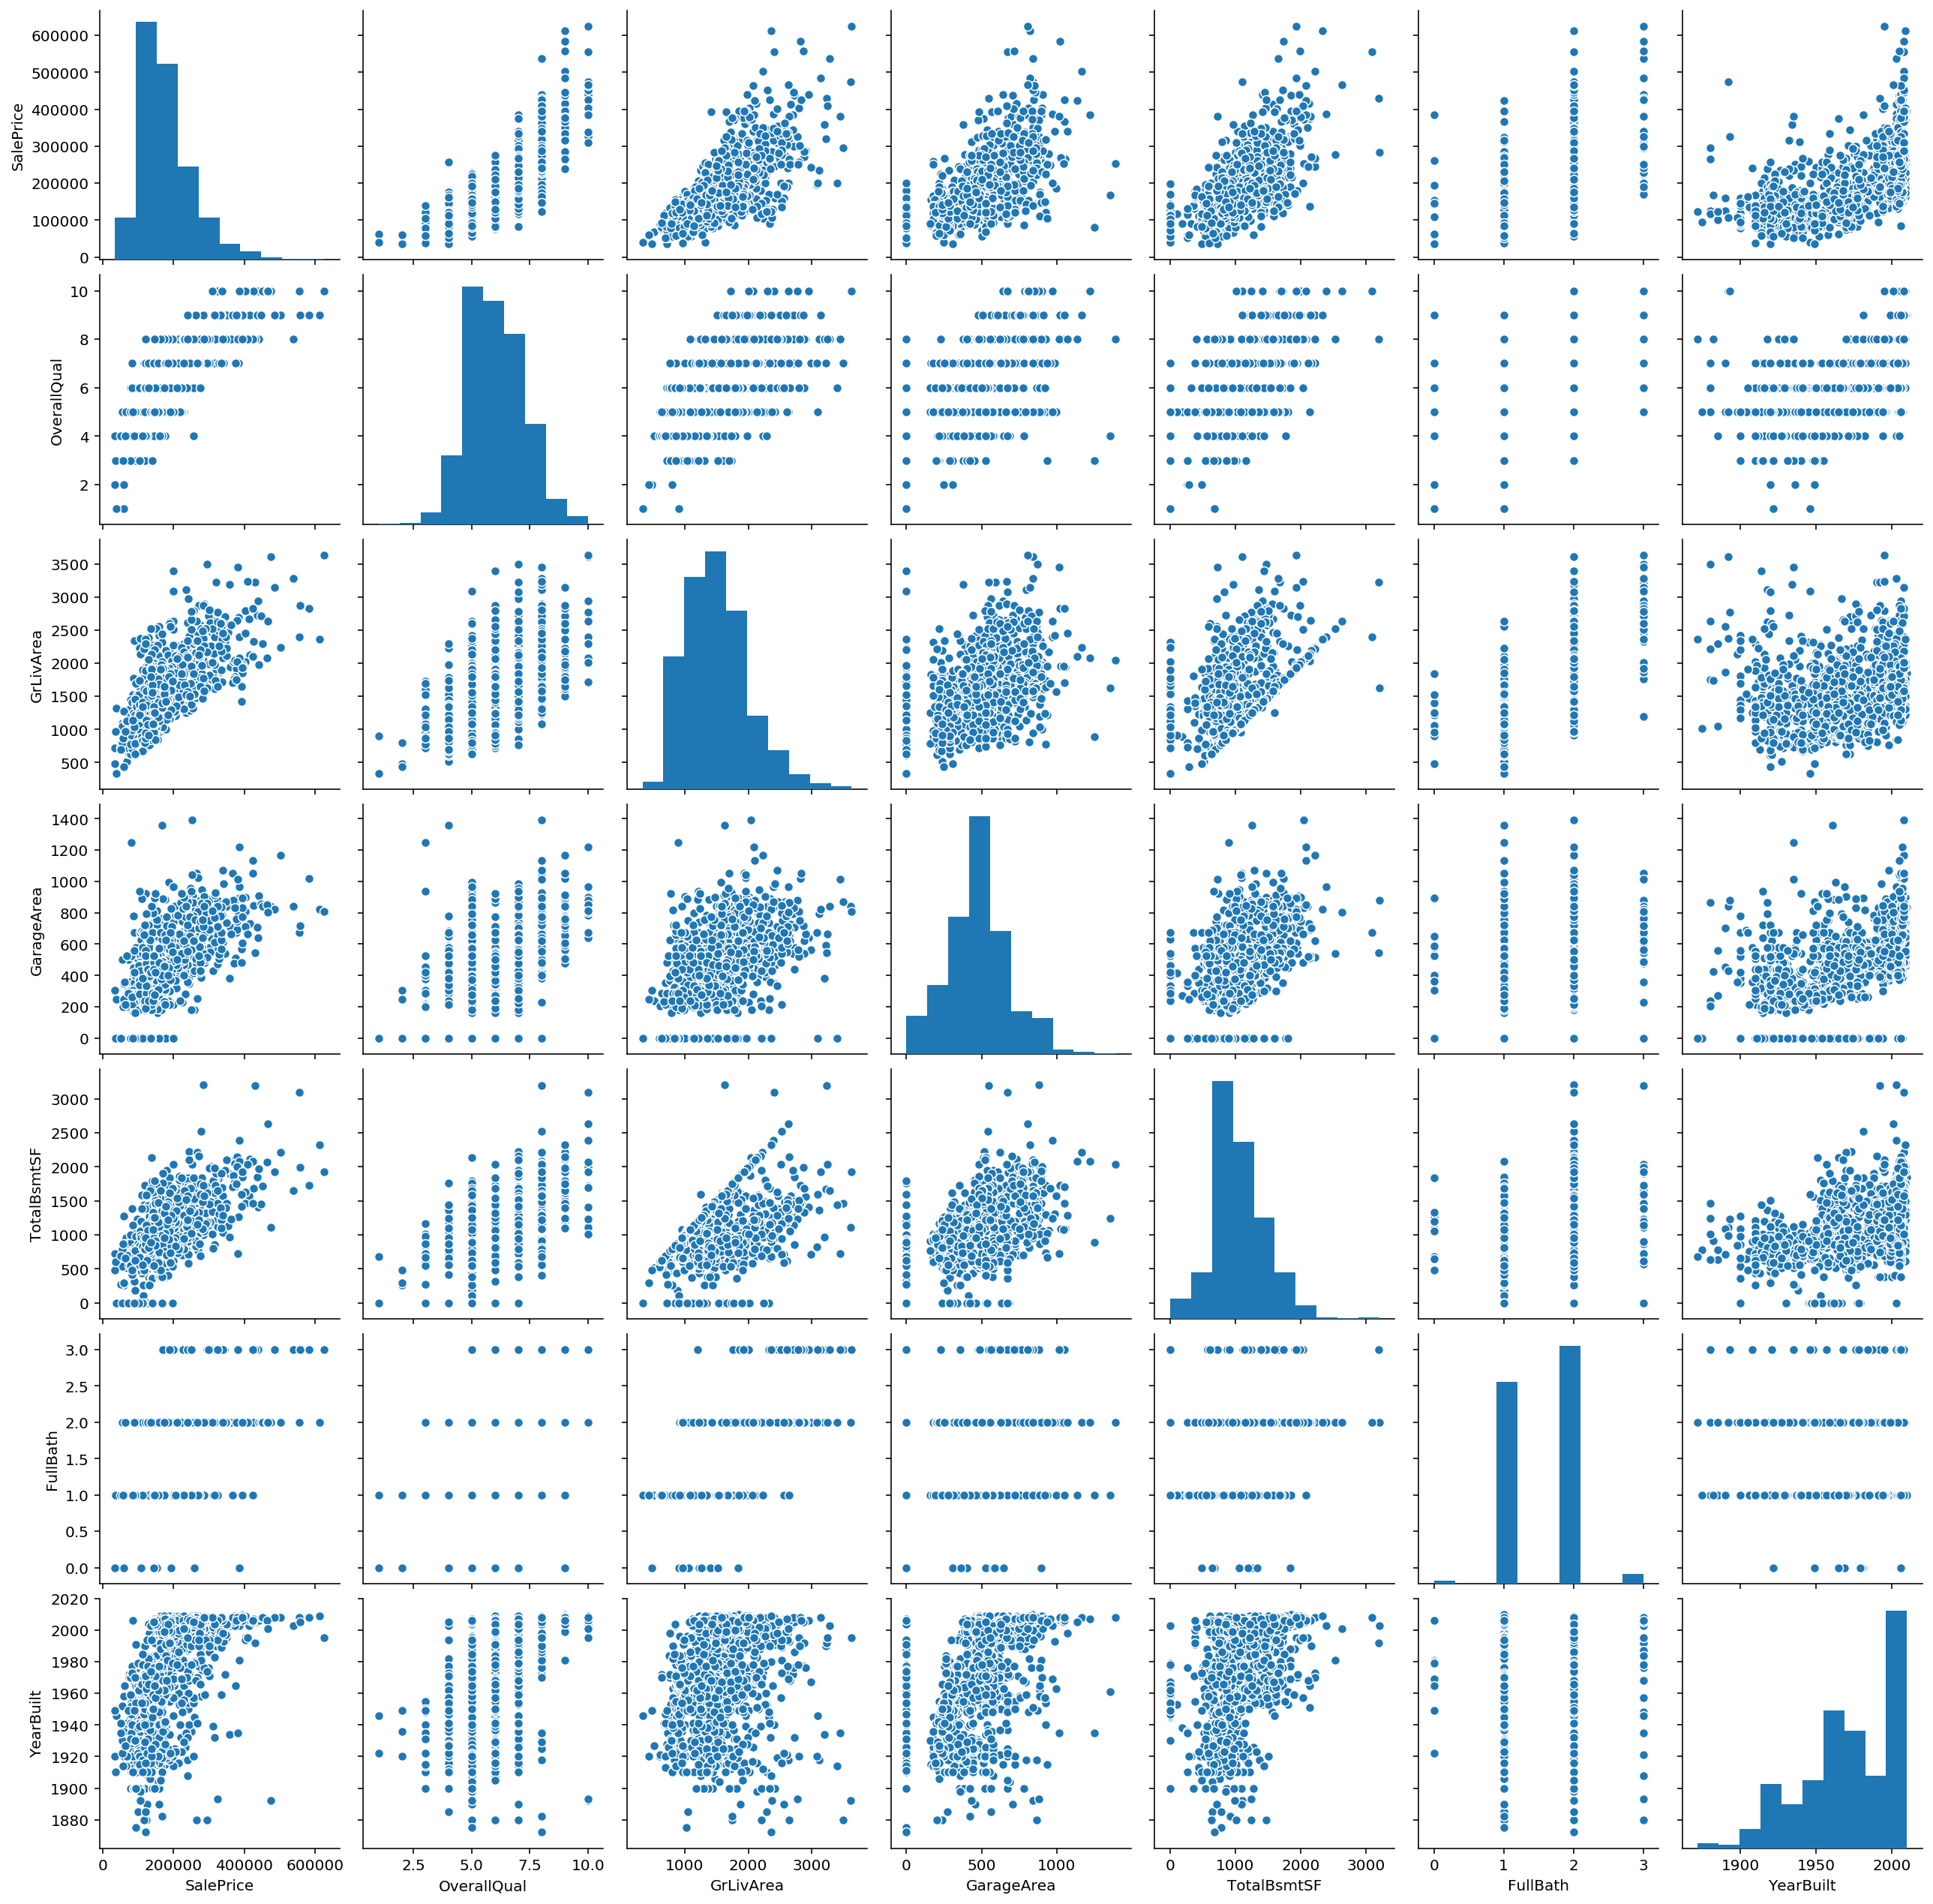

In [11]:
columns = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['SalePrice']>740000)].index)
sns.pairplot(train[columns], height = 2.5)

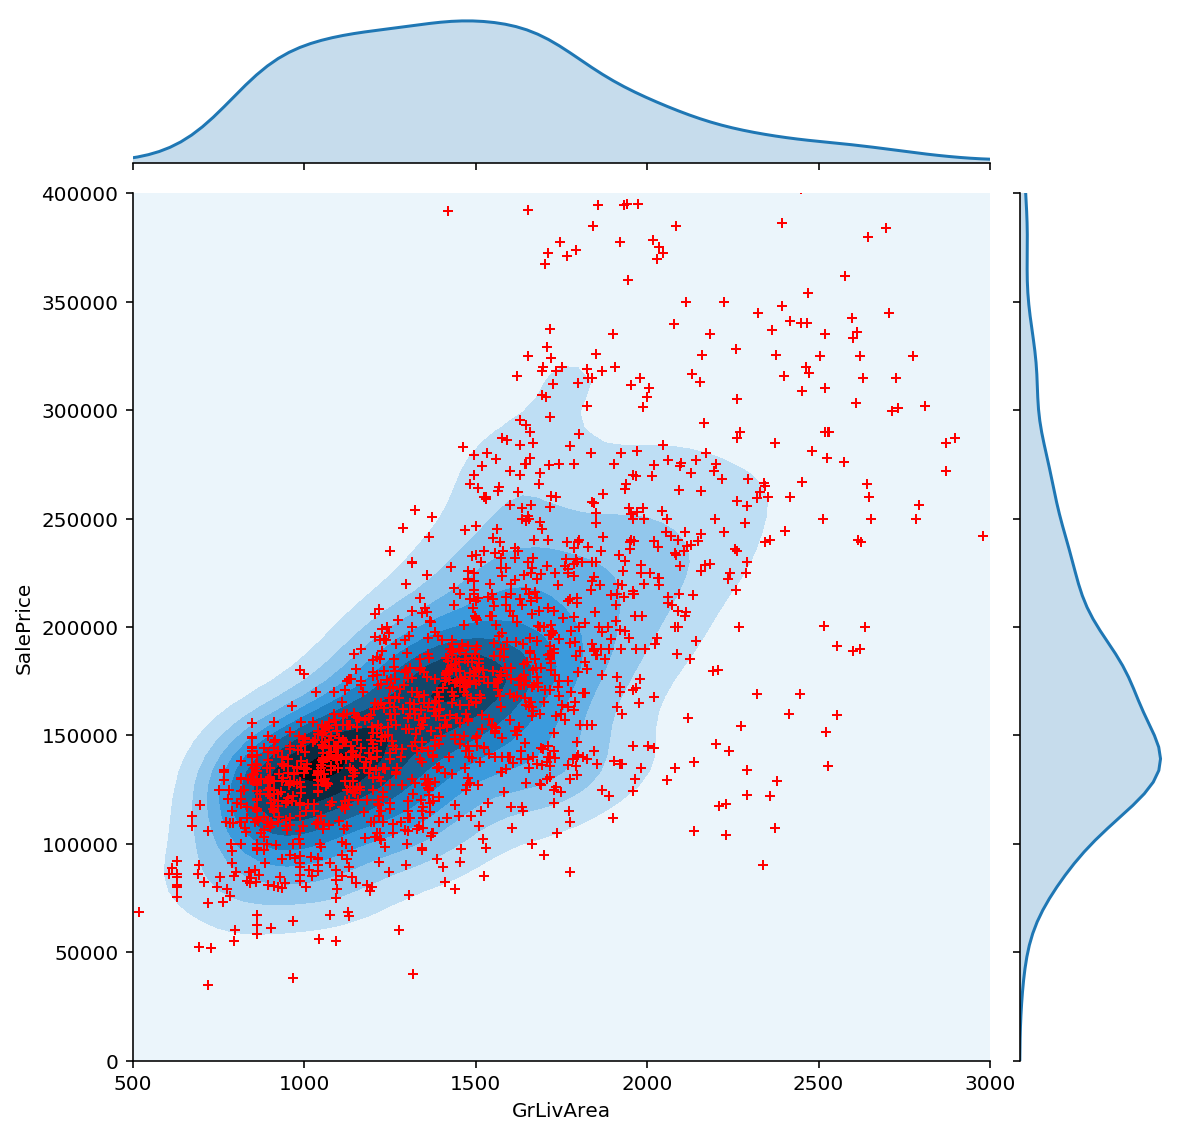

In [12]:
plot = sns.jointplot(x="GrLivArea", y="SalePrice", data=train, kind="kde", height=8)
plot.ax_marg_x.set_xlim(500, 3000)
plot.ax_marg_y.set_ylim(0,400000)
plot.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
plt.show()

### Categorical Variables

One thing we noticed earlier is that there are a great deal of categorical variables in the data set which will not have been identified using .corr(). Let's see how many we are dealing with and which variables seem important.

In [13]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

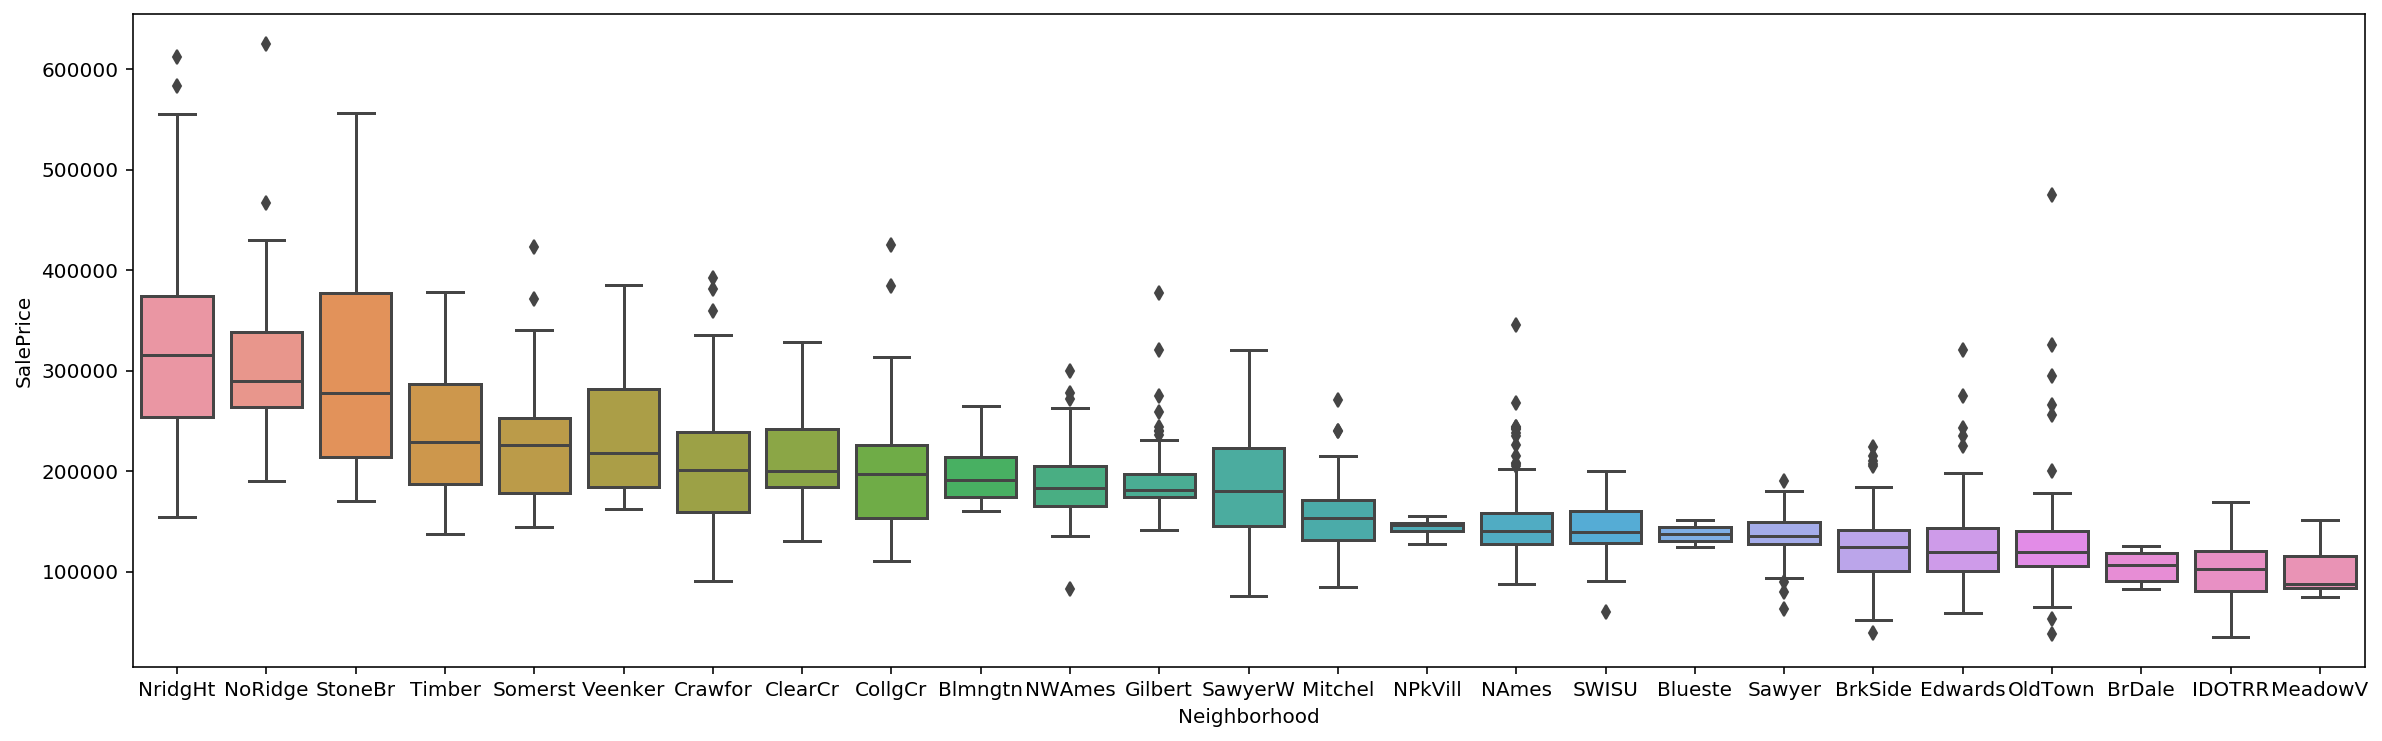

In [14]:
plt.figure(figsize=(20,6))
order = train.groupby(by='Neighborhood').median()['SalePrice'].sort_values(ascending=False).index
sns.boxplot(data=train, x='Neighborhood', y='SalePrice', order=order)

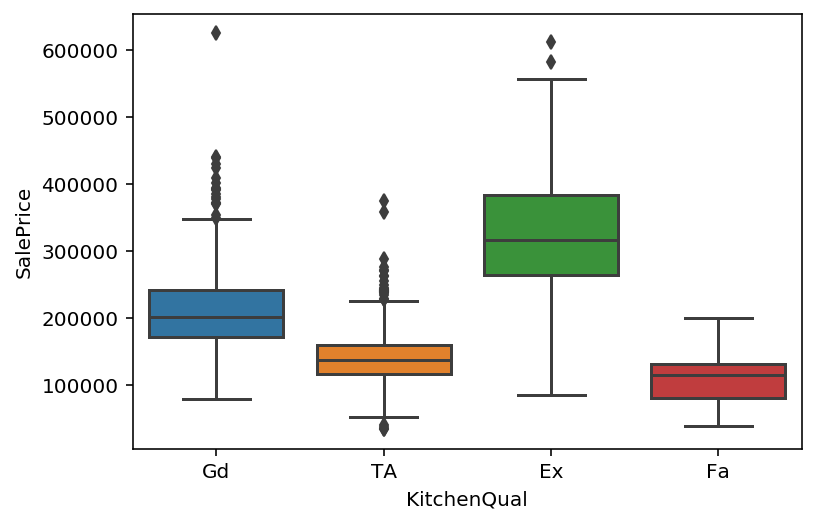

In [15]:
sns.boxplot(data=train, x='KitchenQual', y='SalePrice')

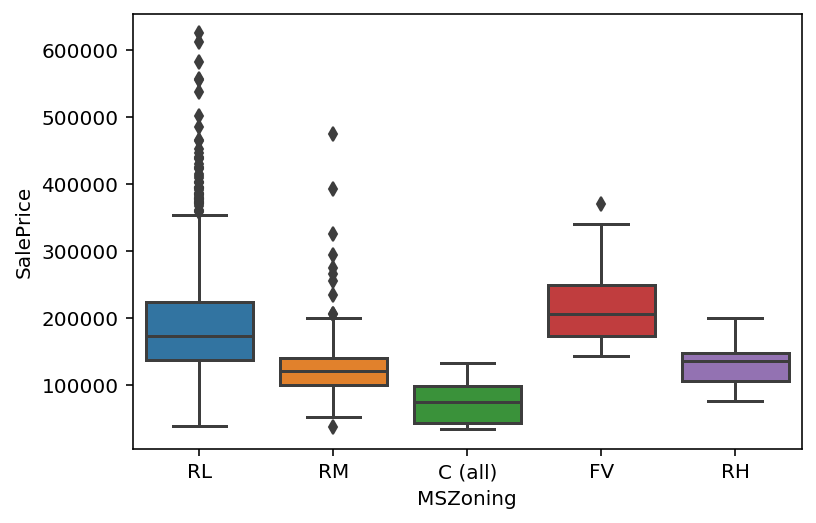

In [16]:
sns.boxplot(data=train, x='MSZoning', y='SalePrice')

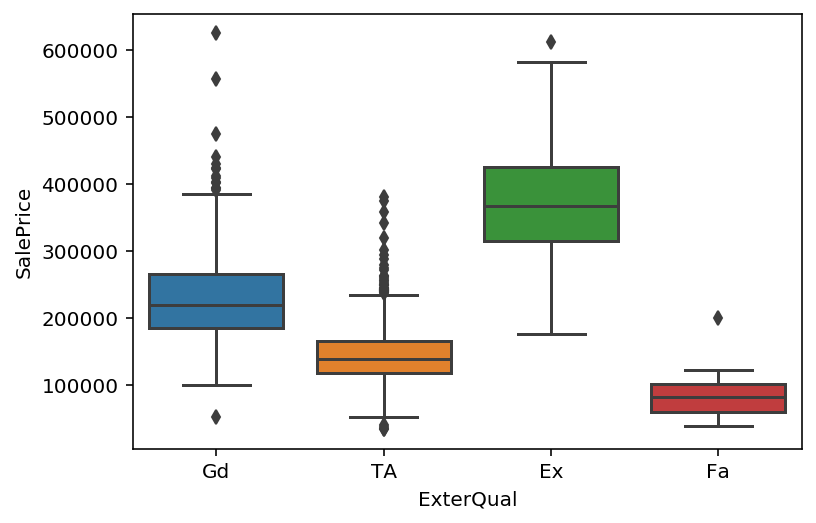

In [17]:
sns.boxplot(data=train, x='ExterQual', y='SalePrice')

In [18]:
train.groupby(by='GarageQual').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
GarageQual,,,,,,,,,,,,,,,,,,,,,
Ex,3,3,3,3,3,3,0,3,3,3,...,3,0,1,1,3,3,3,3,3,3
Fa,48,48,48,46,48,48,10,48,48,48,...,48,0,10,4,48,48,48,48,48,48
Gd,14,14,14,11,14,14,2,14,14,14,...,14,1,3,0,14,14,14,14,14,14
Po,3,3,3,3,3,3,1,3,3,3,...,3,0,1,0,3,3,3,3,3,3
TA,1307,1307,1307,1060,1307,1307,69,1307,1307,1307,...,1307,4,249,46,1307,1307,1307,1307,1307,1307


In [19]:
ratings = {'Fa' : 0, 'TA' : 1, 'Gd' : 2, 'Ex' : 3}
train['KitchenQual'] = train['KitchenQual'].map(ratings)
train['ExterQual'] = train['ExterQual'].map(ratings)
test['KitchenQual'] = test['KitchenQual'].map(ratings)
test['ExterQual'] = test['ExterQual'].map(ratings)

In [20]:
from scipy.stats import pointbiserialr
kpbc = pointbiserialr(train['KitchenQual'],train['SalePrice'])
epbc = pointbiserialr(train['ExterQual'],train['SalePrice'])
print('Kitchen Quality Correlation:')
print(kpbc)
print(' ')
print('External Quality Correlation:')
print(epbc)

Kitchen Quality Correlation:
PointbiserialrResult(correlation=0.6662166938363219, pvalue=1.7953728328094677e-187)
 
External Quality Correlation:
PointbiserialrResult(correlation=0.6946277151248881, pvalue=3.0666494343482574e-210)


Firstly, we can see that we have 43 categorical variables to deal with. We can assess their relationship with SalePrice by using Boxplots quite easily. There are a number of Variables titled with 'Qual' which give a rating from Fair to Excellent which look quite promising. However many of these have been lazily categorised as Average >90% of the time, meaning they won't tell us a great deal. Additionally, there are some variables which are incomplete, with many NaN values, such as PoolQC, which can be ignored.

There are 4 promising variables we should assess, which intuitively should influence SalePrice; KitchenQual, ExterQual, MSZoning & Neighborhood. For two of these, which rate quality, we can logically map these into numerical scores and check that they have a strong Point Biserial Correlation with SalePrice which is significant. Fortunately, this does seem to be the case with strong correlations >0.65 and very low pvalues <0.05.

### Data Preprocessing
Now that we have selected our variables we will need to prepare them before fitting our models. Firstly, I will log transform all numeric variables with a skew greater than 1. Next I will check for any null values in the test set and replace with the average of each category. Finally, I'll utilise pd.get_dummies to convert our two remaining categorical variables.

In [21]:
train = train[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt','KitchenQual','ExterQual','MSZoning','Neighborhood']].copy()
test = test[['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt','KitchenQual','ExterQual','MSZoning','Neighborhood']].copy()

In [22]:
continuous = train.dtypes[train.dtypes != "object"].index
skew_var = train[continuous].apply(lambda x: skew(x.dropna()))
skew_var = skew_var[skew_var > 0.8]
skew_var = skew_var.index
train[skew_var] = np.log1p(train[skew_var])

In [23]:
skew_var = ['GrLivArea','ExterQual']
test[skew_var] = np.log1p(test[skew_var])

In [24]:
test.isnull().sum().sort_values(ascending=False)

MSZoning        4
KitchenQual     1
TotalBsmtSF     1
GarageArea      1
Neighborhood    0
ExterQual       0
YearBuilt       0
FullBath        0
GrLivArea       0
OverallQual     0
dtype: int64

In [25]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train = train.fillna(train.mean())
test = test.fillna(test.mean())

### Regression & Evaluation

Let's begin by fitting a very simple linear regression model to our data using only one variable, OverallQual, which seems to be one of our most important variables. This should give us a benchmark for comparing more complex models back to. Additionally, let's create a blank dataframe to hold our RMSE & Adjusted R squared results from each model. Adjusted R squared will be defined as per the function below where we will pass in R squared, n (# of examples) & k (# of variables). Additionally, we will also convert RMSE back into real dollar terms for ease of interpretation.

In [26]:
evaluation = pd.DataFrame({'Model': [],
                           'RMSE log':[],
                           'RMSE $':[],
                           'R-squared (train)':[],
                           'Adj R-squared (train)':[],
                           'R-squared (test)':[],
                           'Adj R-squared (test)':[]})

In [27]:
def adjR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice',axis=1), 
                                                    train['SalePrice'], test_size=0.25, 
                                                    random_state=3)

X_train = np.array(X_train['OverallQual'], dtype=pd.Series).reshape(-1,1)
X_test = np.array(X_test['OverallQual'], dtype=pd.Series).reshape(-1,1)

In [29]:
slr = linear_model.LinearRegression()
slr.fit(X_train,y_train)
pred = slr.predict(X_test)

In [30]:
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rmsedollar = float(format(np.sqrt(metrics.mean_squared_error(np.expm1(pred),np.expm1(y_test))),'.2f'))
rtrsm = float(format(slr.score(X_train, y_train),'.3f'))
artrcm = float(format(adjR2(slr.score(X_train, y_train),X_train.shape[0],X_train.shape[1]),'.3f'))
rtesm = float(format(slr.score(X_test, y_test),'.3f'))
artecm = float(format(adjR2(slr.score(X_test, y_test),X_test.shape[0],X_test.shape[1]),'.3f'))
r = evaluation.shape[0]
evaluation.loc[r] = ['Simple Linear Regression',rmsesm,rmsedollar,rtrsm,artrcm,rtesm,artecm]
evaluation

,Model,RMSE log,RMSE $,R-squared (train),Adj R-squared (train),R-squared (test),Adj R-squared (test)
0,Simple Linear Regression,0.224,39345.14,0.677,0.677,0.652,0.652


In [31]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice',axis=1), 
                                                    train['SalePrice'], test_size=0.25, 
                                                    random_state=3)

In [32]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_sub = scaler.transform(test)

In [33]:
mlr = linear_model.LinearRegression()
mlr.fit(X_train,y_train)
pred = mlr.predict(X_test)

In [34]:
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rmsedollar = float(format(np.sqrt(metrics.mean_squared_error(np.expm1(pred),np.expm1(y_test))),'.2f'))
rtrsm = float(format(mlr.score(X_train, y_train),'.3f'))
artrcm = float(format(adjR2(mlr.score(X_train, y_train),X_train.shape[0],X_train.shape[1]),'.3f'))
rtesm = float(format(mlr.score(X_test, y_test),'.3f'))
artecm = float(format(adjR2(mlr.score(X_test, y_test),X_test.shape[0],X_test.shape[1]),'.3f'))
r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Linear Regression',rmsesm,rmsedollar,rtrsm,artrcm,rtesm,artecm]
evaluation

,Model,RMSE log,RMSE $,R-squared (train),Adj R-squared (train),R-squared (test),Adj R-squared (test)
0,Simple Linear Regression,0.224,39345.14,0.677,0.677,0.652,0.652
1,Multiple Linear Regression,0.144,24688.69,0.887,0.883,0.856,0.840


### Regularized Linear Regression

Based on the above metrics we can see that our single variable Linear Regression actually performed pretty well with a R squared of 0.652 on the test set and an RMSE (Dollars) of $39,345. Note that adjusted R squared and R squared are identical when we have only one variable in our model. When we add all of our features in and carry out linear regression the model performs even better, with a lower RMSE and a higher adjusted R squared. 

However, we can see that on the test set the R squared values are lower which can be an indication of over-fitting. Over-fitting is an issued caused by 'high variance' and 'low bias' in your model, meaning that it is potentially fitting too well to the training data and resulting in worse performance on the test set.

We can combat over-fitting by using regularization, which can help to simplify the model enough so that it is more widely applicable to the test data. Regularization typically takes an alpha value as a parameter which can control how flexible the model is, too high and the model will be too simple, too low and the model could overfit. We will try two different popular regularization methods; Ridge & Lasso.

In [35]:
alpha = 0.5
rlr = linear_model.Ridge(alpha=alpha)
rlr.fit(X_train,y_train)
pred = rlr.predict(X_test)

rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rmsedollar = float(format(np.sqrt(metrics.mean_squared_error(np.expm1(pred),np.expm1(y_test))),'.2f'))
rtrsm = float(format(rlr.score(X_train, y_train),'.3f'))
artrcm = float(format(adjR2(rlr.score(X_train, y_train),X_train.shape[0],X_train.shape[1]),'.3f'))
rtesm = float(format(rlr.score(X_test, y_test),'.3f'))
artecm = float(format(adjR2(rlr.score(X_test, y_test),X_test.shape[0],X_test.shape[1]),'.3f'))
r = evaluation.shape[0]
evaluation.loc[r] = ['Ridge Regression - alpha = ' + str(alpha),rmsesm,rmsedollar,rtrsm,artrcm,rtesm,artecm]
evaluation = evaluation.sort_values(by = 'Adj R-squared (test)', ascending=False)
evaluation

,Model,RMSE log,RMSE $,R-squared (train),Adj R-squared (train),R-squared (test),Adj R-squared (test)
2,Ridge Regression - alpha = 0.5,0.144,24702.22,0.887,0.883,0.857,0.841
1,Multiple Linear Regression,0.144,24688.69,0.887,0.883,0.856,0.840
0,Simple Linear Regression,0.224,39345.14,0.677,0.677,0.652,0.652


In [36]:
llr = linear_model.LassoCV(eps=0.001, n_alphas=100)
llr.fit(X_train,y_train)
pred = llr.predict(X_test)

rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rmsedollar = float(format(np.sqrt(metrics.mean_squared_error(np.expm1(pred),np.expm1(y_test))),'.2f'))
rtrsm = float(format(llr.score(X_train, y_train),'.3f'))
artrcm = float(format(adjR2(llr.score(X_train, y_train),X_train.shape[0],X_train.shape[1]),'.3f'))
rtesm = float(format(llr.score(X_test, y_test),'.3f'))
artecm = float(format(adjR2(llr.score(X_test, y_test),X_test.shape[0],X_test.shape[1]),'.3f'))
r = evaluation.shape[0]
evaluation.loc[r] = ['Lasso CV Regression',rmsesm,rmsedollar,rtrsm,artrcm,rtesm,artecm]
evaluation = evaluation.sort_values(by = 'Adj R-squared (test)', ascending=False)
evaluation

,Model,RMSE log,RMSE $,R-squared (train),Adj R-squared (train),R-squared (test),Adj R-squared (test)
2,Ridge Regression - alpha = 0.5,0.144,24702.22,0.887,0.883,0.857,0.841
3,Lasso CV Regression,0.144,24638.80,0.887,0.883,0.857,0.841
1,Multiple Linear Regression,0.144,24688.69,0.887,0.883,0.856,0.840
0,Simple Linear Regression,0.224,39345.14,0.677,0.677,0.652,0.652


In [37]:
coef = pd.Series(llr.coef_, index = train.drop('SalePrice',axis=1).columns)
imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'LassoCV Coefficients')

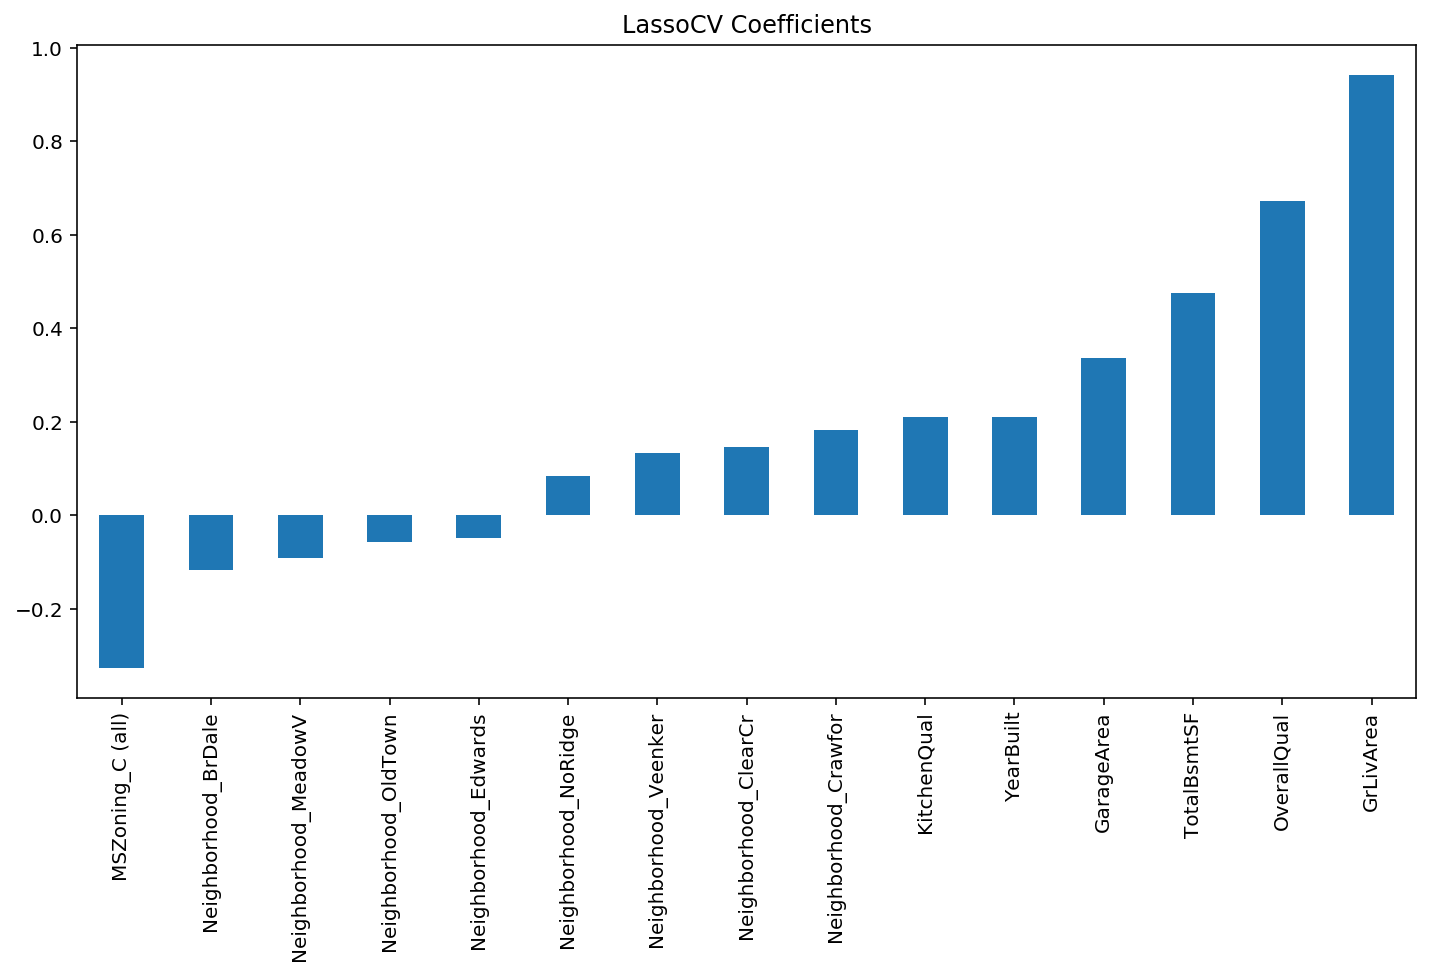

In [38]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
imp_coef.plot(kind = "bar")
plt.title("LassoCV Coefficients")

### Conclusion

It looks like Ridge Regression only provided marginal improvements, if any. However. these models are slightly more sophisticated than basic Linear regression. For example, LassoCV will automatically determine which variables are important and set the coefficients of any others to zero. Above we can see that by plotting the most important coefficients it is clear that GrLivArea & OverallQual are out in front.

A very popular and powerful model used in Machine Learning currently is XGBoost, let's see if it performs any better than our regression models so far.

In [39]:
from xgboost import XGBRegressor
xg = XGBRegressor(n_estimators=1500,learning_rate=0.01, max_depth=5)
xg.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)
pred = xg.predict(X_test)

In [40]:
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rmsedollar = float(format(np.sqrt(metrics.mean_squared_error(np.expm1(pred),np.expm1(y_test))),'.2f'))

In [41]:
print(rmsesm,rmsedollar)

0.146 25689.47


In [42]:
submission = (0.6*np.expm1(xg.predict(test_sub))) + (0.4*np.expm1(llr.predict(test_sub)))
test_id = pd.read_csv("test.csv")
submission = pd.DataFrame({"id":test_id.Id, "SalePrice":submission})
submission.to_csv("submission.csv", index = False)